In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from optimization import *
torch.set_default_dtype(torch.float64)
from PROGRAMS.data_generating_process import *
from PROGRAMS.likelihood import *
from PROGRAMS.programs import *
from PROGRAMS.run_pyro import *
import time

import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import MCMC, NUTS
import pyro.distributions as dist

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [3]:
def neg_log_likelihood(data, dist, idx):
    log_likelihood = torch.log(dist.gm.marg_pdf(data, idx))
    return - torch.sum(log_likelihood)

def run_optimization(name, data, params_init, true_params, eps, sensitivity_analysis=False, lr =0.05, steps = 100):
    soga_code = get_program(name)
    compiledFile = compile2SOGA_text(soga_code)
    cfg = produce_cfg_text(compiledFile)
    smooth_cfg(cfg, smooth_eps=eps)

    params_dict = initialize_params(params_init)  
    output_dist = start_SOGA(cfg, params_dict)
    data_var_list = get_vars(name)
    data_var_index = [output_dist.var_list.index(var) for var in data_var_list]
    data = torch.tensor(data, dtype=torch.float64)
    loss = lambda dist : neg_log_likelihood(data, dist, data_var_index)

    # repeat t
    loss_list, time, iters = optimize(cfg, params_dict, loss, n_steps=steps, lr=lr)

    if sensitivity_analysis:
        error_list = []
        #use the average error
        avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
        return avg_error

    # print results:
    for key, value in params_dict.items():
        print(f"{key}: {value.item()}")
    
    # get the true value of the parameters from true_params and compute the relative error
    for key, true_value in true_params.items():
        estimated_value = params_dict[key].item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

    #calculate average error
    avg_error = np.mean([abs(params_dict[key].item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
    print(f"Average error: {avg_error}")
    
    #save losses to a file
    with open(f'losses_csv/loss_{name}.txt', 'w') as f:
        for loss in loss_list:
            f.write(f"{loss}\n")
    # plot the loss
    plt.plot(loss_list)
    plt.xlabel('Iteration')
    plt.ylabel('Negative Log-Likelihood')
    plt.title(f'Loss over iterations for {name}')
    plt.show()


In [4]:
program = 'bernoulli'  # Change this to test other programs
data_size = 1000
true_params, init_params = get_params(program)
data = generate_dataset(program, data_size, true_params)

p: 0.5099999999998635  loss: -5295.669565217521
p: 0.5199954901618926  loss: -5302.928256611861
p: 0.5299870442458441  loss: -5310.100666373242
p: 0.5399773514298913  loss: -5317.249820124724
p: 0.5499706798569404  loss: -5324.432523504033
p: 0.5599723227103098  loss: -5331.6983251686215
p: 0.5699880574507163  loss: -5339.08856508411
p: 0.5800236372524671  loss: -5346.635463461661
p: 0.5900843230046331  loss: -5354.361225223138
p: 0.6001744554797972  loss: -5362.277158717855
p: 0.6102970608360638  loss: -5370.382832223388
p: 0.6204534785023267  loss: -5378.665315146888
p: 0.6306429984321673  loss: -5387.098571232298
p: 0.640862494317226  loss: -5395.643087432672
p: 0.6511060402745332  loss: -5404.245833636516
p: 0.6613645005554808  loss: -5412.840654410793
p: 0.671625084982383  loss: -5421.3491935556885
p: 0.6818708673870357  loss: -5429.682444663646
p: 0.6920802708669048  loss: -5437.743004969272
p: 0.7022265329879599  loss: -5445.428084207316
p: 0.7122771770634072  loss: -5452.633283

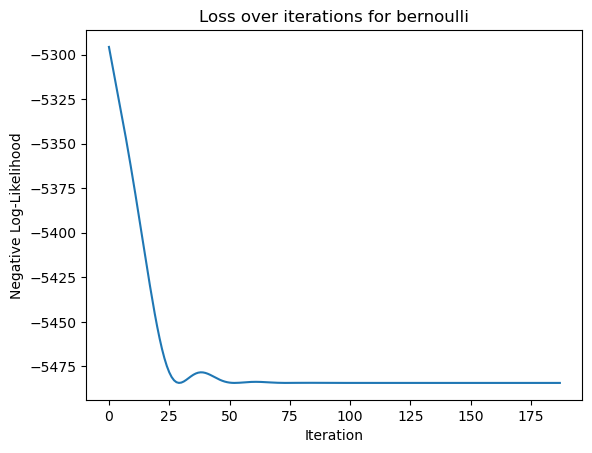

In [5]:
run_optimization(program, data, init_params, true_params, eps=0.001, lr=0.01, steps=500)


In [8]:
error_list = []
for eps in [0.1, 0.01, 0.001, 0.0001]:
    #print(f"Running optimization for eps={eps}")
    loss_list, params, error, time_degas, number_of_iterations = run_optimization(program, data, init_params, true_params, eps=eps, sensitivity_analysis=True, lr=0.001, steps= 100)
    error_list.append(error)

# plot the error as a function of eps
eps_values = [0.1, 0.01, 0.001, 0.0001]
plt.plot(eps_values, error_list, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Epsilon (log scale)')
plt.ylabel('Relative Error (log scale)')
plt.title(f'Relative Error vs Epsilon for {program}')
plt.grid(True)
plt.show()

#print the error values
for eps, error in zip(eps_values, error_list):
    print(f"Epsilon: {eps}, Error: {error}")

#save errors to a file
with open(f'errors_csv/errors_{program}.txt', 'w') as f:
    for eps, error in zip(eps_values, error_list):
        f.write(f"{eps},{error}\n")

p: 0.5009999999999863  loss: -690.4993792294274
p: 0.5019999466239043  loss: -691.2309148496743
p: 0.5029998078292289  loss: -691.9609640068505
p: 0.5039995543412165  loss: -692.6895752963387
p: 0.5049991597259605  loss: -693.4167988508611
p: 0.5059986004492946  loss: -694.1426863466786
p: 0.5069978559212084  loss: -694.8672910023047
p: 0.5079969085256122  loss: -695.590667569676
p: 0.5089957436354461  loss: -696.3128723177739
p: 0.509994349613295  loss: -697.0339630088091
p: 0.5109927177978222  loss: -697.753998867149
p: 0.5119908424764769  loss: -698.4730405412488
p: 0.5129887208450666  loss: -699.1911500589265
p: 0.5139863529548971  loss: -699.9083907763729
p: 0.5149837416482878  loss: -700.6248273213573
p: 0.5159808924833529  loss: -701.3405255311192
p: 0.5169778136490079  loss: -702.0555523854919
p: 0.517974515871206  loss: -702.769975935804
p: 0.5189710123114477  loss: -703.4838652301532
p: 0.5199673184586147  loss: -704.1972902356152
p: 0.5209634520151859  loss: -704.91032175798

TypeError: cannot unpack non-iterable numpy.float64 object

## variational inference


In [6]:
model, guide = get_model_guide(program)
run_inference(model, guide, model_params=(data_size,torch.tensor(data, dtype=torch.float64)), n_steps=1000, lr=0.05)
for pyro_param in pyro.get_param_store().get_all_param_names():
    print(f"{pyro_param}: {pyro.param(pyro_param).item()}")

for key, true_value in true_params.items():
        estimated_value = pyro.param(key + "_map").item()
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(pyro.param(key + "_map").item() - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")

p_map: 0.8210090169034392
Error in p: 0.026261271129298935
Average error: 0.026261271129298935


## MCMC

In [16]:
import arviz as az
rhat = 2.0
num_samples = 0
warmup_steps = 50

while rhat > 1.05 and num_samples < 10000:
        num_samples += 500
        if num_samples > 2000:
                warmup_steps += 50
        elif num_samples > 5000:
                warmup_steps += 100

        # Run the inference with num_samples=500, warmup_steps=50 and check convergence with R-hat and Neff
        pyro.clear_param_store()
        # Do the same with MCMC
        nuts_kernel = NUTS(model, adapt_step_size=True)
        mcmc = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=4)
        start = time.time()
        mcmc.run((data_size, torch.tensor(data, dtype=torch.float64)))
        end = time.time()
        # Get total time
        total_time = end - start
        print(f"Total MCMC runtime: {total_time:.3f} seconds")
        #mcmc.summary()
        samples = mcmc.get_samples(group_by_chain=True)
        idata = az.convert_to_inference_data(samples)
        print(az.summary(idata, round_to=4))
        rhat_all = az.rhat(idata)
        valid_rhat = rhat_all.where(~np.isnan(rhat_all), drop=True)
        rhat = valid_rhat.to_array().max().item()
        neff = az.ess(idata).to_array().min().item()
        print(f"R-hat: {rhat}")
        print(f"Neff: {neff}")


print(f"R-hat maximum: {rhat}")
print(f"Neff minimum: {neff}")
print(f"Num samples: {num_samples}")


for key, true_value in true_params.items():
        estimated_value = torch.mean(samples[key])
        error = abs(estimated_value - true_value)/abs(true_value)
        print(f"Error in {key}: {error}")

avg_error = np.mean([abs(torch.mean(samples[key]) - true_value)/abs(true_value) for key, true_value in true_params.items()])
print(f"Average error: {avg_error}")

Warmup [1]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [2]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [3]:   0%|          | 0/550 [00:00, ?it/s]

Warmup [4]:   0%|          | 0/550 [00:00, ?it/s]

Total MCMC runtime: 5.612 seconds
     mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p  0.8199  0.0123  0.7982   0.8446     0.0005   0.0003  695.5297  821.4723   

    r_hat  
p  1.0037  
R-hat: 1.0037396327967747
Neff: 695.5296661180109
R-hat maximum: 1.0037396327967747
Neff minimum: 695.5296661180109
Num samples: 500
Error in p: 0.024879811456986756
Average error: 0.024879811456986756
